In [1]:
import torch
import torch.nn as nn
import torch.utils.data as tud
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
#Importing the dataset and Changing to tensors

train_clean = np.load('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/Clean_Norm.npy')
train_16X16 = np.load('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/Input_16x16.npy')

val_16X16 = np.load('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/Validation_16x16.npy')
val_clean = np.load('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/Clean_Val.npy')


test_clean = np.load('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/Test_Norm.npy')
test_16X16 = np.load('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/Test_16x16.npy')

Output = torch.Tensor(train_clean)
Input = torch.Tensor(train_16X16)

val_input = torch.Tensor(val_16X16)
val_output = torch.Tensor(val_clean)

test_output = torch.Tensor(test_clean)
test_input = torch.Tensor(test_16X16)


dataset = tud.TensorDataset(Input, Output)
loader = tud.DataLoader(dataset, batch_size = 32, shuffle = True)

val_dataset = tud.TensorDataset(val_input, val_output)
val_loader = tud.DataLoader(val_dataset, batch_size = 32, shuffle = True)

test_dataset = tud.TensorDataset(test_input, test_output)
test_loader = tud.DataLoader(test_dataset, batch_size = 100, shuffle = True)

In [83]:
batch = next(iter(test_loader))
In, Out = batch
#images.shape
Out.shape


torch.Size([100, 1, 32, 32])

In [3]:
class DeepInverse(nn.Module):
    
    def __init__(self):
        super(DeepInverse, self).__init__()
        
        
        self.d_conv1 = nn.ConvTranspose2d(in_channels = 1, out_channels = 16, kernel_size = 17, stride = 1)

        
        #Encode
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 9, stride = 1, padding = 4)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 5, stride = 1, padding = 2)
        self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = 7, stride = 1, padding = 3)

        self.fc1 = nn.Linear(256,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,1024)
        

        self.pool = nn.MaxPool2d(3, 3)
        
        #Decoder
        
        self.d_conv1 = nn.ConvTranspose2d(16,4,2, stride = 1)
        self.d_conv2 = nn.ConvTranspose2d(4,1,2, stride = 1)
        
        
    def forward(self,x):
        
        #Encoder
        
        x = x.view(-1,256)
    
        #x = F.relu(self.d_conv1(x))

        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))

        x = x.view(-1, 1, 32, 32)
        
        #First iter through convolutional layer
        #print(x.shape)
        x = F.relu(self.conv1(x))
        
        
        #Second iter through convolutional layer
        #print(x.shape)
        x = F.relu(self.conv2(x))
        
        #one layer of maxpooling
        #x = self.pool(x);
        
        #Third iter through convolutional layer
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        
        
        #Fourth iter through convolutional layer
        #print(x.shape)
        x = F.relu(self.conv4(x))
        
        #Decode?
        
        #x = F.relu(self.d_conv1(x))
        
        #x = F.sigmoid(self.d_conv2(x))
        
        #output layer
        #x = F.softmax(x, dim = 1)
        
        return x

In [78]:
deepinverse = DeepInverse()
loss_list = []
val_loss_list = []

loss_function = nn.MSELoss()
optimizer = optim.SGD(deepinverse.parameters(), lr = 0.009)

total_loss = 0
total_val_loss = 0


for epoch in range(300):

    for batch in loader:
    
        Input, Output = batch
    
        optimizer.zero_grad()
    
        prediction = deepinverse(Input)
        loss = loss_function(prediction, Output)
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item()
        
    
    
    
    for val_in, val_out in val_loader:
        
        val_pred = deepinverse(val_in)
        val_loss = loss_function(val_pred, val_out)
        total_val_loss += val_loss.item()
        
    print('Epoch: {}    Training Loss: {:.6f}    Validation Loss: {:.6f}'.format(epoch, total_loss/len(loader), total_val_loss/len(val_loader)))

    val_loss_list.append(total_val_loss/len(val_loader))
    total_val_loss = 0

    loss_list.append(total_loss/len(loader))
    total_loss = 0
                     

Epoch: 0    Training Loss: 0.021849    Validation Loss: 0.016477
Epoch: 1    Training Loss: 0.013913    Validation Loss: 0.014732
Epoch: 2    Training Loss: 0.012513    Validation Loss: 0.013753
Epoch: 3    Training Loss: 0.011566    Validation Loss: 0.013072
Epoch: 4    Training Loss: 0.010807    Validation Loss: 0.012315
Epoch: 5    Training Loss: 0.010169    Validation Loss: 0.011648
Epoch: 6    Training Loss: 0.009616    Validation Loss: 0.011185
Epoch: 7    Training Loss: 0.009125    Validation Loss: 0.010624
Epoch: 8    Training Loss: 0.008691    Validation Loss: 0.010231
Epoch: 9    Training Loss: 0.008297    Validation Loss: 0.009837
Epoch: 10    Training Loss: 0.007938    Validation Loss: 0.009544
Epoch: 11    Training Loss: 0.007607    Validation Loss: 0.009192
Epoch: 12    Training Loss: 0.007302    Validation Loss: 0.008880
Epoch: 13    Training Loss: 0.007025    Validation Loss: 0.008598
Epoch: 14    Training Loss: 0.006776    Validation Loss: 0.008490
Epoch: 15    Trainin

Epoch: 124    Training Loss: 0.002231    Validation Loss: 0.002890
Epoch: 125    Training Loss: 0.002223    Validation Loss: 0.003132
Epoch: 126    Training Loss: 0.002214    Validation Loss: 0.002954
Epoch: 127    Training Loss: 0.002207    Validation Loss: 0.002964
Epoch: 128    Training Loss: 0.002198    Validation Loss: 0.002916
Epoch: 129    Training Loss: 0.002190    Validation Loss: 0.002935
Epoch: 130    Training Loss: 0.002182    Validation Loss: 0.003184
Epoch: 131    Training Loss: 0.002175    Validation Loss: 0.002894
Epoch: 132    Training Loss: 0.002167    Validation Loss: 0.002867
Epoch: 133    Training Loss: 0.002159    Validation Loss: 0.002925
Epoch: 134    Training Loss: 0.002151    Validation Loss: 0.003045
Epoch: 135    Training Loss: 0.002144    Validation Loss: 0.003049
Epoch: 136    Training Loss: 0.002137    Validation Loss: 0.003035
Epoch: 137    Training Loss: 0.002130    Validation Loss: 0.003054
Epoch: 138    Training Loss: 0.002123    Validation Loss: 0.00

Epoch: 247    Training Loss: 0.001650    Validation Loss: 0.002138
Epoch: 248    Training Loss: 0.001648    Validation Loss: 0.002150
Epoch: 249    Training Loss: 0.001645    Validation Loss: 0.002285
Epoch: 250    Training Loss: 0.001643    Validation Loss: 0.002100
Epoch: 251    Training Loss: 0.001641    Validation Loss: 0.002404
Epoch: 252    Training Loss: 0.001637    Validation Loss: 0.002137
Epoch: 253    Training Loss: 0.001634    Validation Loss: 0.002260
Epoch: 254    Training Loss: 0.001632    Validation Loss: 0.002121
Epoch: 255    Training Loss: 0.001631    Validation Loss: 0.002312
Epoch: 256    Training Loss: 0.001627    Validation Loss: 0.002300
Epoch: 257    Training Loss: 0.001624    Validation Loss: 0.002377
Epoch: 258    Training Loss: 0.001621    Validation Loss: 0.002124
Epoch: 259    Training Loss: 0.001619    Validation Loss: 0.002198
Epoch: 260    Training Loss: 0.001618    Validation Loss: 0.002177
Epoch: 261    Training Loss: 0.001614    Validation Loss: 0.00

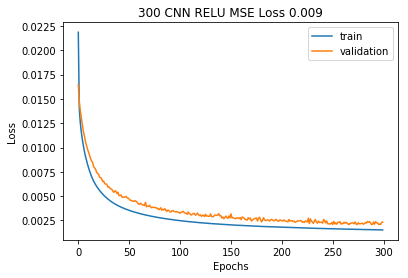

In [82]:
plt.figure()
plt.plot(loss_list); plt.title('300 CNN RELU MSE Loss 0.009');plt.xlabel('Epochs');plt.ylabel('Loss')
plt.plot(val_loss_list); plt.title('300 CNN RELU MSE Loss 0.009');plt.xlabel('Epochs');plt.ylabel('Loss');
plt.legend({'train' , 'validation'});
plt.savefig('300 Epoch CNN RELU MSE Loss 0.009.png');

In [80]:
tot_loss = 0
avg_loss = 0

#deepinverse.eval()

for IN, OUT in test_loader:
    
    test_prediction = deepinverse(IN)
    tot_loss = loss_function(test_prediction, OUT)
    avg_loss += tot_loss.item()

print("Loss = {:.16f}".format((avg_loss) / len(test_loader)))



Loss = 0.0015208317998126


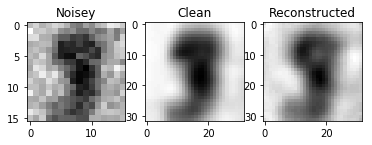

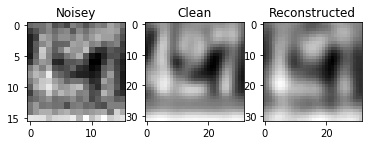

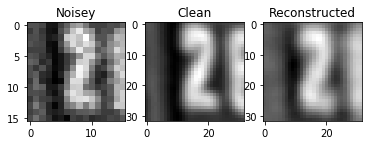

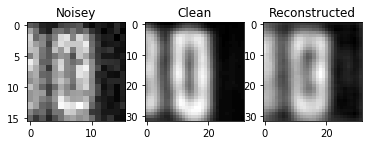

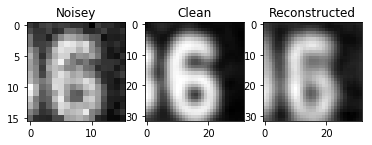

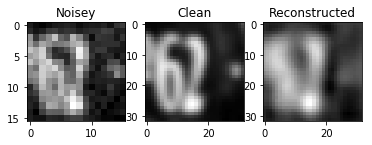

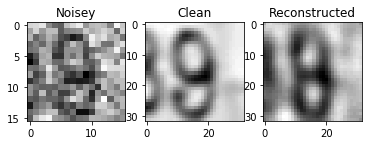

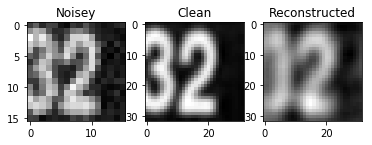

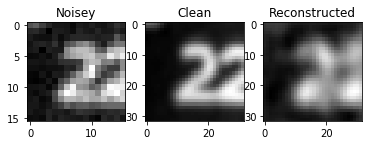

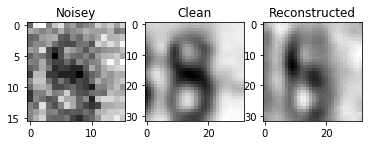

In [84]:
for i in range(0,10):
    

    testt = test_prediction.squeeze(1)
    testt.shape
    tst = testt[i]
    a = tst.detach()

    OUT_1 = OUT.squeeze(1)
    OUT_1 = OUT_1[i]
    Before = OUT_1.detach()

    IN.shape
    IN_1 = IN.squeeze(1)
    IN_1 = IN_1[i]
    Clean3 = IN_1.detach()
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Clean3, cmap = 'gray'); plt.title('Noisey')
    plt.sca(axarr[1]); 
    plt.imshow(Before, cmap = 'gray'); plt.title('Clean')
    plt.sca(axarr[2]); 
    plt.imshow(a, cmap = 'gray'); plt.title('Reconstructed')
    f.savefig('Example{}.png'.format(i+1))

In [120]:
loss_list = np.asarray(loss_list);
loss_cnn_sgd = np.asarray(loss_cnn_sgd);

In [121]:

#np.save('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/Linear_Loss_Train', loss_list)
np.save('/home/urabe/Documents/Research/Professor Marcia/DataSet For House Numbers/Final_Dataset/CNN_Relu_MSE_Loss2.0_Train',loss_list)


In [50]:
torch.save(deepinverse.state_dict(), '/home/urabe/Documents/Research/Professor Marcia/Code/Model/300-epochCNN_SGD_LR2.0_Relu.pt')

Loss = 0.0078645123586316


In [175]:
len(test_loader)

26032

In [176]:
loss_function(test_prediction,OUT)

tensor(0.0007, grad_fn=<MseLossBackward>)

In [16]:
test_prediction.shape

torch.Size([32, 1, 32, 32])

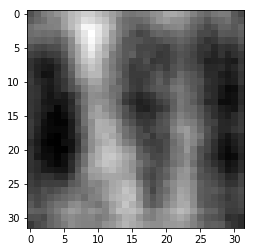

In [23]:
testt = test_prediction.squeeze(1)
testt.shape
tst = testt[3]
a = tst.detach()



plt.imshow(a, cmap = 'gray')

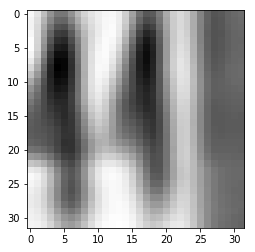

In [24]:
OUT_1 = OUT.squeeze(1)
OUT_1 = OUT_1[3]
Before = OUT_1.detach()



plt.imshow(Before, cmap = 'gray')

In [183]:
torch.max(abs(a - Before))

tensor(0.1062)

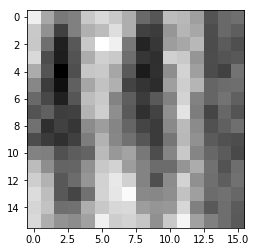

In [28]:
IN.shape
IN_1 = IN.squeeze(1)
IN_1 = IN_1[3]
Clean3 = IN_1.detach()
plt.imshow(Clean3, cmap = 'gray')

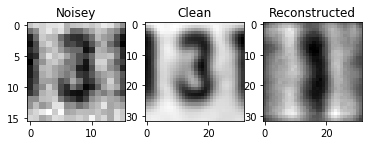

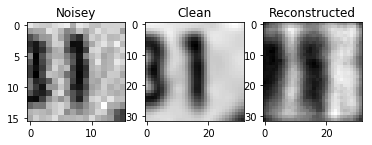

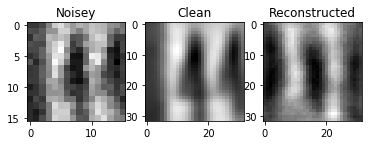

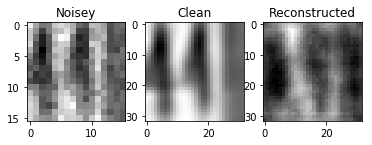

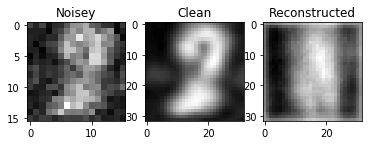

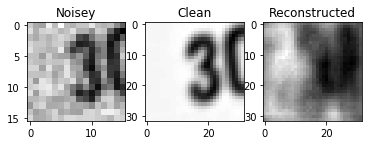

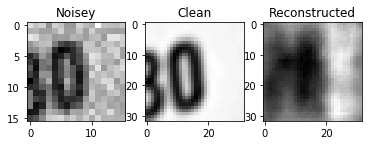

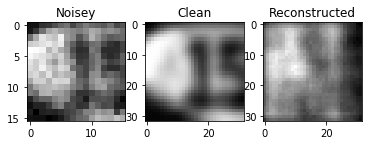

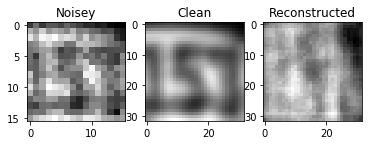

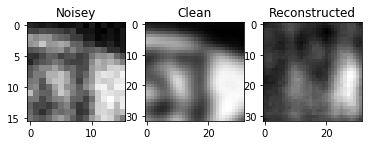

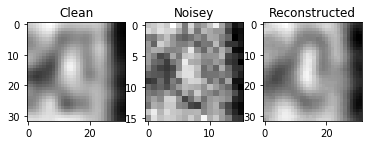

In [153]:
f, axarr = plt.subplots(nrows=1,ncols=3)
plt.sca(axarr[0]); 
plt.imshow(Clean3, cmap = 'gray'); plt.title('Clean')
plt.sca(axarr[1]); 
plt.imshow(Before, cmap = 'gray'); plt.title('Noisey')
plt.sca(axarr[2]); 
plt.imshow(a, cmap = 'gray'); plt.title('Reconstructed')
f.savefig('Example5_lr:2.0.png')

In [124]:
ping = next(iter(test_loader))
In, Out = ping
In.shape
#Out.shape


torch.Size([26032, 1, 16, 16])

OSError: [Errno 12] Cannot allocate memory